## Imports

In [201]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic

In [202]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [203]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [204]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [205]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

### Data

In [206]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

### Space parameters

In [207]:
N = 100

In [208]:
frank2d = Frank2D(N, Rout, [inc, pa, dra, ddec])
u_ft = frank2d._FT._Un
v_ft = frank2d._FT._Vn
q = frank2d._FT.q
min_freq = v_ft[1]

In [209]:
u1, u2 = np.meshgrid(u_ft, u_ft)
v1, v2 = np.meshgrid(v_ft, v_ft)
r = np.sqrt((u1-u2)**2 + (v1-v2)**2)
r_f = r.flatten()

input = [u_ft, v_ft]

In [210]:
m = -0.33
c = -0.1
exp_c = np.exp(c)

In [211]:
l = 2e5
H_41 = 2*1.897367*l

# Wendland

In [147]:
def P_k(r, k):
    if k == 0:
        return np.ones_like(r)  # P_0(r) = 1
    elif k == 1:
        return 4*r +1  # P_1(r) = 4r + 1
    elif k == 2:
        return (35/3)*r**2 +6*r + 1  # P_2(r) = 35r^2 + 18r + 3
    else:
        raise ValueError("k must be 0, 1, or 2.")

### Entire Wendland Kernel

In [148]:
def factorSE_kernel(m = m, c = c):
    q1 = np.hypot(u1, v1)
    q2 = np.hypot(u2, v2)
    min_freq = v_ft[1]
    print(min_freq)

    def power_spectrum(q, m, c):
        q[q == 0] = min_freq
        return (q**m)*np.exp(c)

    p1 = power_spectrum(q1, m, c)
    p2 = power_spectrum(q2, m, c)
    
    factor = np.sqrt(p1 * p2)
    return factor

In [18]:
def Wendland_kernel(amplitude, H, threshold = 1, j = 4, k = 1):
    r = np.sqrt((u1-u2)**2 + (v1-v2)**2)
    r_normalized = r/H

    factor = (1 - r_normalized)**j
    factor[r_normalized > threshold] = 0
    
    print(r' type?:  ϕ_{', j-k,',',  k, '}')

    return  amplitude * factor * P_k(r_normalized, k)

In [19]:
factor = factorSE_kernel()

51566.20156177409


In [20]:
matrixW = Wendland_kernel(factor, H = H_41, j = 4, k = 1)

 type?:  ϕ_{ 3 , 1 }


In [21]:
#plt.figure(figsize=(5,3))
#plt.plot(r_f, matrixW.flatten(), ls = 'None', marker = 'x', label = f'l = {4*l:.0e}')
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
#plt.show()

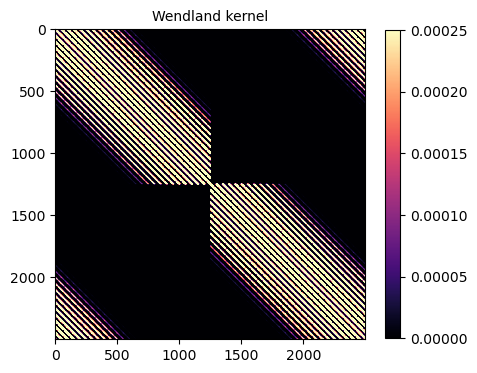

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(matrixW, cmap =  'magma', vmin = 0, vmax = 0.00025)
plt.colorbar(shrink=0.8)
plt.title(r'Wendland kernel', size = 10)
plt.show()

### Optimized version

In [212]:
l = 9e4
H_41 = 2*1.897367*l

In [213]:
from scipy.sparse import csr_matrix

In [194]:
def power_spectrum(q):
    if not np.isscalar(q):  
        q[q == 0] = min_freq
    elif q == 0:
        q = min_freq
    return (q**m)*exp_c

In [195]:
power_spectrum_q1 = power_spectrum(q)

In [196]:
def Wendland_kernel_row(i, H = H_41, j = 4, k = 1):
    amp_i = np.sqrt(power_spectrum_q1 * power_spectrum(q[i]))

    r_i = np.sqrt((u_ft-u_ft[i])**2 + (v_ft-v_ft[i])**2)
    r_normalized_i = r_i/H
    threshold = 1

    factor_i = (1 - r_normalized_i)**j
    factor_i[r_normalized_i > threshold] = 0

    Wendland_Kernel_row =  amp_i * factor_i * P_k(r_normalized_i, k)

    return Wendland_Kernel_row

In [197]:
#i = 1
#np.where(Wendland_kernel_row(i) != matrixW[i])

In [198]:
frank2d.preprocess_vis(u_deproj, v_deproj, vis_deproj, Weights)
vis_gridded, weights_gridded = frank2d._gridded_data["vis"], frank2d._gridded_data["weights"]

  --> time = 0.01  min |  0.39 seconds


In [199]:
def create_system_csr_wendland(N, weights = weights_gridded, H=H_41, j=4, k=1):
    data_A = []
    indices_A = []
    indptr_A = [0]

    data_Aprecond = []
    indices_Aprecond = []
    indptr_Aprecond = [0]

    data_b = []
    indices_b = []
    indptr_b = [0]

    for i in range(N**2):  
        row = Wendland_kernel_row(i, H, j, k)

        non_zero_indices = np.nonzero(row)[0]
        non_zero_values = row[non_zero_indices]
        
        final_weights = weights[non_zero_indices]

        weighted_non_zero_values = non_zero_values * final_weights

        data_b.extend(weighted_non_zero_values)
        indices_b.extend(non_zero_indices)
        indptr_b.append(len(data_b))

        diagonal_pos = np.searchsorted(non_zero_indices, i)

        if i == 3:
           print(non_zero_indices)
        
        weighted_non_zero_values[diagonal_pos] += 1

        diag_element_i = weighted_non_zero_values[diagonal_pos]
        diag_element_i_m1 = diag_element_i**(-1)

        data_A.extend(weighted_non_zero_values)
        indices_A.extend(non_zero_indices)
        indptr_A.append(len(data_A))

        data_Aprecond.extend([diag_element_i**(-1)])
        indices_Aprecond.extend([i])
        indptr_Aprecond.append(len(data_Aprecond))
        
    data_A = np.array(data_A)
    indices_A = np.array(indices_A)
    indptr_A = np.array(indptr_A)

    data_Aprecond = np.array(data_Aprecond)
    indices_Aprecond = np.array(indices_Aprecond)
    indptr_Aprecond = np.array(indptr_Aprecond)

    data_b = np.array(data_b)
    indices_b = np.array(indices_b)
    indptr_b = np.array(indptr_b)

    A_csr = csr_matrix((data_A, indices_A, indptr_A), shape=(N**2, N**2))
    A_precond_csr = csr_matrix((data_Aprecond, indices_Aprecond, indptr_Aprecond), shape=(N**2, N**2))
    b_csr = csr_matrix((data_b, indices_b, indptr_b), shape=(N**2, N**2))
    
    return A_csr, A_precond_csr, b_csr

In [200]:
A_csr, A_precond_csr, b_csr = create_system_csr_wendland(N)

[   1    2    3    4    5  102  103  104  203 9803 9902 9903 9904]


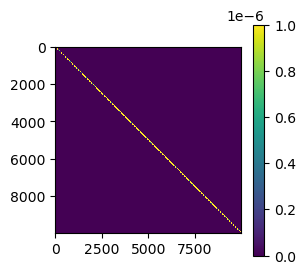

In [125]:
A_precond = A_precond_csr.toarray(order='C')
plt.figure(figsize=(3,3))
plt.imshow(A_precond, vmin = 0, vmax = 1e-6)
plt.colorbar()

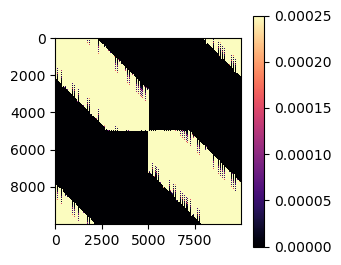

In [126]:
A = A_csr.toarray(order='C')
plt.figure(figsize=(3,3))
plt.imshow(A, cmap =  'magma', vmin = 0, vmax = 0.00025)
plt.colorbar()

In [127]:
from scipy.sparse.linalg import LinearOperator

def linear_op_A():
    def SWI(x):
        return A_csr.dot(x)

    return LinearOperator((N**2, N**2), matvec=SWI)

def linear_op_A_precond():
    def SWI_(x):
        return A_precond_csr.dot(x)

    return LinearOperator((N**2, N**2), matvec=SWI_)

def linear_op_b():
    def SW(x):
        return b_csr.dot(x)

    bop =  LinearOperator((N**2, N**2), matvec=SW)
    return bop.matvec(vis_gridded)

### Corroborating everything is in order

##### b

In [53]:
b1 = b_csr.dot(vis_gridded)
b1

array([11096242.37377371 +1978.06420613j,
       10676912.54521498 -7023.35587253j,
        8700563.10781064-13153.36496452j, ...,
        7261881.49387927+29188.1380241j ,
        8666835.42729257+27004.2825727j ,
       10014629.57551553+22484.88871187j])

In [54]:
b2 = np.array([np.dot(Wendland_kernel_row(i)*weights_gridded, vis_gridded) for i in range(N**2)])
b2

array([11096242.37377369 +1978.06420613j,
       10676912.54521498 -7023.35587253j,
        8700563.10781065-13153.36496452j, ...,
        7261881.49387927+29188.1380241j ,
        8666835.42729258+27004.2825727j ,
       10014629.57551554+22484.88871187j])

In [59]:
np.where(b1 != b2)
# JUST SMALL DIFFERENCES IN DECIMALS

(array([   0,    1,    2, ..., 2497, 2498, 2499]),)

#### A precond

In [56]:
Aprecond1 = A_precond_csr.dot(vis_gridded)
Aprecond1

array([6.40674928e-08-4.43281402e-12j, 7.56801305e-08+9.27477180e-12j,
       1.12869680e-07-2.34561850e-09j, ...,
       5.80653475e-08+1.83056208e-09j, 7.70876628e-08+1.54687103e-09j,
       4.65026932e-08+1.44778807e-10j])

In [57]:
Aprecond2 = np.array([ ((Wendland_kernel_row(i)[i] * weights_gridded[i] + 1)**(-1) * vis_gridded[i]) for i in range(N**2) ])
Aprecond2

array([6.40674928e-08-4.43281402e-12j, 7.56801305e-08+9.27477180e-12j,
       1.12869680e-07-2.34561850e-09j, ...,
       5.80653475e-08+1.83056208e-09j, 7.70876628e-08+1.54687103e-09j,
       4.65026932e-08+1.44778807e-10j])

In [58]:
np.where(Aprecond1 != Aprecond2)

(array([], dtype=int64),)

#### A

In [60]:
A1 = A_csr.dot(vis_gridded)
A1

array([11096242.62292252 +1978.0641889j ,
       10676912.73555179 -7023.3558492j ,
        8700563.20806157-13153.3670479j , ...,
        7261881.55787463+29188.14004161j,
        8666835.51892853+27004.2844115j ,
       10014629.73045037+22484.88919424j])

In [109]:
A2 = np.array([
    np.dot(np.add(Wendland_kernel_row(i)*weights_gridded, np.eye(1, N**2, i).flatten()), vis_gridded) for i in range(N**2)
    ])
A2

array([11096242.62292251 +1978.0641889j ,
       10676912.73555178 -7023.3558492j ,
        8700563.20806158-13153.3670479j , ...,
        7261881.55787463+29188.14004161j,
        8666835.51892853+27004.2844115j ,
       10014629.73045038+22484.88919424j])

In [62]:
np.where(A1 != A2)

(array([   0,    1,    2, ..., 2497, 2498, 2499]),)

### Fitting

#### From scratch

In [79]:
from scipy.sparse.linalg._isolve.utils import make_system

def _get_atol_rtol(name, b_norm, atol=0., rtol=1e-5):
    """
    A helper function to handle tolerance normalization
    """
    if atol == 'legacy' or atol is None or atol < 0:
        msg = (f"'scipy.sparse.linalg.{name}' called with invalid `atol`={atol}; "
            "if set, `atol` must be a real, non-negative number.")
        raise ValueError(msg)

    print(f'         * rtol: {float(rtol)}')

    atol = max(float(atol), float(rtol) * float(b_norm))
    print(f'         * final tolerance: {atol}')

    return atol, rtol


def bicgstab(A, b, x0=None, *, rtol=1e-7, atol=0., maxiter=None, M=None, callback=None):
    print("     * BICGSTAB")
    A, M, x, b, postprocess = make_system(A, M, x0, b)
    bnrm2 = np.linalg.norm(b)

    atol, _ = _get_atol_rtol('bicgstab', bnrm2, atol, rtol)

    if bnrm2 == 0:
        return postprocess(b), 0

    n = len(b)

    dotprod = np.vdot if np.iscomplexobj(x) else np.dot

    if maxiter is None:
        maxiter = n*10
    print("         * maxiter: ", maxiter)

    matvec = A.matvec
    psolve = M.matvec

    # These values make no sense but coming from original Fortran code
    # sqrt might have been meant instead.
    rhotol = np.finfo(x.dtype.char).eps**2
    omegatol = rhotol

    # Dummy values to initialize vars, silence linter warnings
    rho_prev, omega, alpha, p, v = None, None, None, None, None

    r = b - matvec(x) if x.any() else b.copy()
    rtilde = r.copy()

    for iteration in range(maxiter):
        print("             .. iteration: ", iteration)
        if np.linalg.norm(r) < atol:  # Are we done?
            print("        * CGM converged in ", iteration, " iterations")
            return postprocess(x), 0

        rho = dotprod(rtilde, r)
        if np.abs(rho) < rhotol:  # rho breakdown
            return postprocess(x), -10

        if iteration > 0:
            if np.abs(omega) < omegatol:  # omega breakdown
                return postprocess(x), -11

            beta = (rho / rho_prev) * (alpha / omega)
            p -= omega*v
            p *= beta
            p += r
        else:  # First spin
            s = np.empty_like(r)
            p = r.copy()

        phat = psolve(p)
        v = matvec(phat)
        rv = dotprod(rtilde, v)
        if rv == 0:
            return postprocess(x), -11
        alpha = rho / rv
        r -= alpha*v
        s[:] = r[:]

        if np.linalg.norm(s) < atol:
            x += alpha*phat
            return postprocess(x), 0

        shat = psolve(s)
        t = matvec(shat)
        omega = dotprod(t, s) / dotprod(t, t)
        x += alpha*phat
        x += omega*shat
        r -= omega*t
        rho_prev = rho

        if callback:
            callback(x)

    else:  # for loop exhausted
        # Return incomplete progress
        return postprocess(x), maxiter

In [81]:
print("  *  Constructing linear operators...")
start_time = time.time()

A = linear_op_A()
b = linear_op_b()
A_precond = linear_op_A_precond()

end_time = time.time()
execution_time = end_time - start_time
print(f'     --> time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

# Solve the linear system
print("  *  Solving linear system...")
start_time = time.time()

x, info = bicgstab(A, b, M = A_precond, x0 = vis_gridded, rtol = 1e-12)

end_time = time.time()
execution_time = end_time - start_time
print(f'     --> time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

# Report on the success of the fitting
fit_correctly = np.allclose(A.matvec(x), b)
print("  --> CGM converged?  ", info == 0)
print("  --> Fit correctly?  ", fit_correctly)
if fit_correctly:
    print("                                    !!!!!!!!!!!!!!!!!!!")

  *  Constructing linear operators...
     --> time = 0.00  min |  0.02 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-12
         * final tolerance: 7.168162433755943e-05
         * maxiter:  25000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
             .. iteration:  19
             .. iteration:  20
             .. iteration:  21
             .. iteration:  22
             .. iteration:  23
             .. iteration:  24
         

In [82]:
u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']

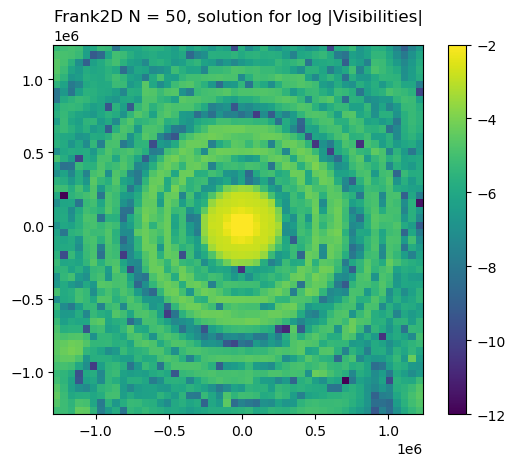

In [83]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(x.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

#### Trying using Frank2D

In [128]:
x0_frank1d = frank2d.frank1d_solution(u, v, Vis, Weights)

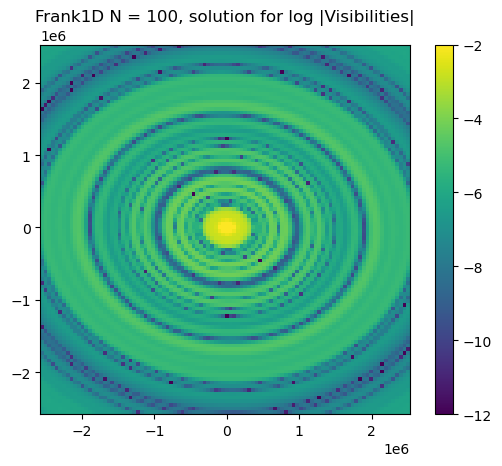

In [132]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(x0_frank1d.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank1D N = {N}, solution for log |Visibilities|')
plt.colorbar()

In [133]:
method = IterativeSolverMethod(vis_gridded, weights_gridded, 'SquareExponential', frank2d._FT,
                                             method = 'bicgstab', x0 = x0_frank1d, rtol = 1e-10)

In [134]:
method.set_A(linear_op_A())
method.set_A_precond(linear_op_A_precond())
method.set_b(linear_op_b())

Setting A...
Setting A_precond...
Setting b...


In [135]:
vis_model = method.solve()

  *  Constructing linear operators...
     --> time = 0.00  min |  0.00 seconds
  *  Solving linear system...
ACA
     * BICGSTAB
         * rtol: 1e-10
         * final tolerance: 0.010761752018715286
         * maxiter:  100000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
             .. iteration:  19
             .. iteration:  20
             .. iteration:  21
             .. iteration:  22
             .. iteration:  23
             .. iteration:  24
     

In [97]:
frank2d.sol_visibility = vis_model 

In [98]:
I_model = frank2d.sol_intensity = frank2d._FT.transform_fast(vis_model, direction = 'backward')

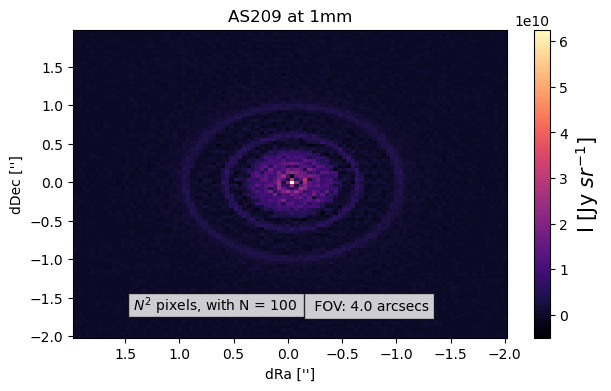

In [99]:
Plot(frank2d).get_image('AS209 at 1mm')

# Frank2D

In [12]:
N = 50
l = 2e5
H_41 = 2*1.897367*l
j, k, H = 4, 1, H_41

In [13]:
start_time = time.time()

#####

frank2d = Frank2D(N, Rout)
frank2d.set_kernel('Wendland', [j, k, H])
frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, method = 'bicgstab', rtol = 1e-12)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel...Wendland
 Wendland Kernel with params =  [4, 1, 758946.8]
Gridding...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:42: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.00  min |  0.22 seconds
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting b...
Setting A_precond...
     --> time = 0.01  min |  0.85 seconds
  *  Solving linear system...
ACA
     * BICGSTAB
         * rtol: 1e-12
         * final tolerance: 7.168162433755944e-05
         * maxiter:  25000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
             .. iteration:

KeyboardInterrupt: 

In [96]:
frank2d._kernel

<bound method Wendland.kernel of <gaussian_process.Wendland object at 0x1481466f0>>

In [121]:
frank2d._method._A.matvec(vis_gridded)

array([968902.12988365  -67.03809926j, 478700.261986    +58.66580382j,
        89042.9511376 -1850.45968878j, ...,
        70530.98519898+2223.55247285j, 108929.85455055+2185.82884169j,
       516202.41756473+1607.1148779j ])

# Let's see the vis solution

In [100]:
u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']

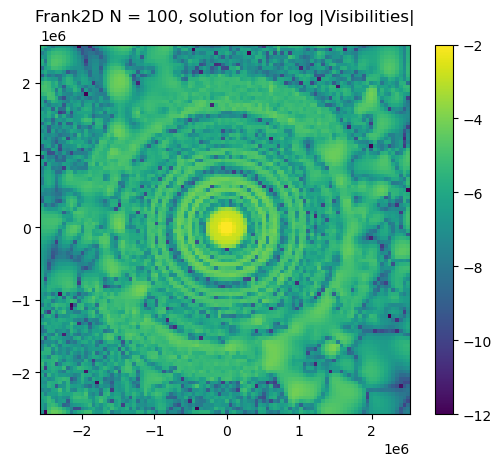

In [101]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_3294/2256721134.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


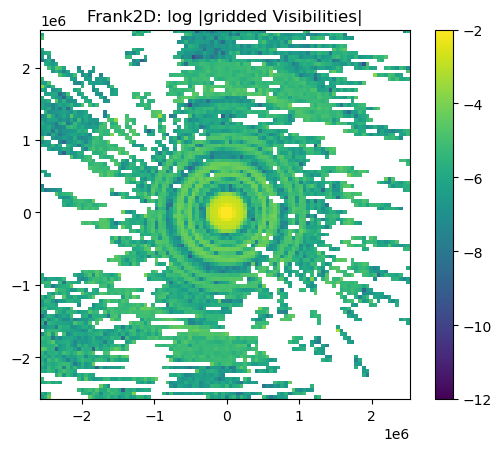

In [102]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |gridded Visibilities|')
plt.colorbar()

In [103]:
r, I = get_radial_profile(frank2d)

In [37]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

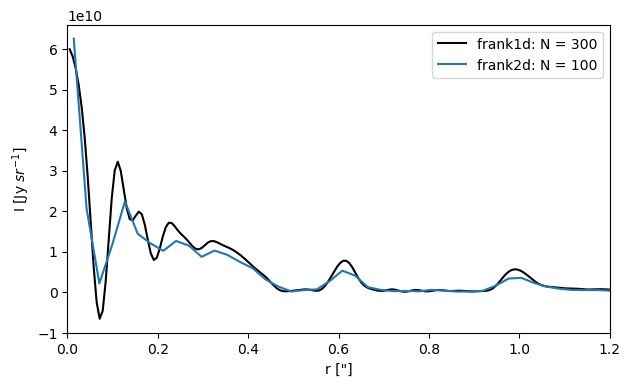

In [104]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r, I, label = f'frank2d: N = {N}')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)           
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.show()

In [ ]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend()
plt.show()